<a href="https://colab.research.google.com/github/basakesin/InsectAI-WG3-STSM/blob/main/train_model_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:40px;">Purpose of 'train_model_with_keras.ipynb'</h1>

The **`train_model_with_keras.ipynb` notebook** provides a user-friendly workflow for training image classification models on custom insect datasets. Its goal is to support researchers and students (even those with limited coding experience) in preparing data, training deep learning models, and exporting them in formats ready for deployment.
To demonstrate the workflow, we tested the code in Google Colab using the [Butterfly & Moths Image Classification (100 species) dataset](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species). You are also free to test the notebook with your own dataset.

With this notebook, users can:  
- **Prepare datasets** by splitting images into training, validation, and test sets.  
- **Select and train a model** from popular backbones (*MobileNetV2*, *EfficientNetB0*, *ResNet50*, *InceptionV3*).  
- **Monitor performance** with accuracy/loss plots and confusion matrices.  
- **Generate a `class_names.txt` file** mapping folder names (species) to model outputs.  
- **Export trained models** in multiple formats: `.keras`, `.tflite`, and TensorFlow `SavedModel`.  
- **Download models** easily with built-in buttons.  

The block diagram of the notebook is illustrated below. It summarizes the workflow step by step, highlighting which steps require user input, which apply defaults, and which only need to be executed without modification.





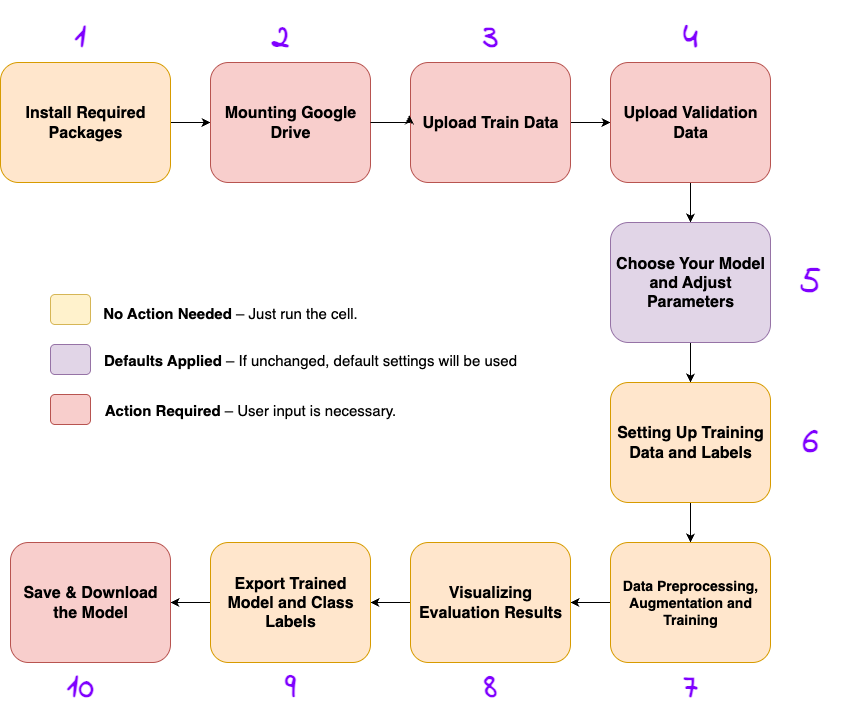



In [1]:
# @title 1-Install Required Packages
!pip install split-folders
import os
import shutil
import itertools
import io
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import (
    EfficientNetB0, MobileNetV2, ResNet50, InceptionV3
)
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre

import splitfolders

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def _zip_dir(src_dir, zip_path):
    # Remove existing zip if present
    if os.path.exists(zip_path):
        os.remove(zip_path)
    base, _ = os.path.splitext(zip_path)
    # shutil.make_archive wants base name without .zip + format
    shutil.make_archive(base, 'zip', root_dir=src_dir)
    return zip_path

def _safe_download(path):
    if os.path.exists(path):
        files.download(path)
        print(f"Downloading: {os.path.basename(path)}")
    else:
        print(f"Not found: {path}")
def on_click_keras(b):
    with out:
        _safe_download(keras_path)
def on_click_h5(b):
    with out:
        _safe_download(h5_path)

def on_click_tflite(b):
    with out:
        _safe_download(tflite_path)

def on_click_savedmodel(b):
    with out:
        if os.path.isdir(sm_dir):
            print("Zipping SavedModel directory...")
            _zip_dir(sm_dir, savedmodel_zip)
            _safe_download(savedmodel_zip)
        else:
            print(f"SavedModel directory not found: {sm_dir}")

def on_click_all(b):
    with out:
        if os.path.isdir(OUTPUT_DIR):
            print("Zipping all outputs...")
            _zip_dir(OUTPUT_DIR, all_outputs_zip)
            _safe_download(all_outputs_zip)
        else:
            print(f"Output folder not found: {OUTPUT_DIR}")

def _on_click(b):
    files.download("class_names.txt")


Prepare Your Dataset


Prepare Your Dataset  
   Organize your insect images so each species has its own folder:

```
train/
├── butterfly/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
└── beetle/
    ├── img1.jpg
    ├── img2.jpg
    └── ...
```

Create a train.zip file to upload.




Mount Google Drive and Upload Your Files

Mount Google Drive and point the notebook to your dataset (train.zip) folder.

Follow these steps:
1. Click on the URL provided in the output.
2. Select the Google account you want to use.
3. Allow Google Colab to access your Google Drive.
4. Choose your zip file and upload it.

In [2]:
# @title 2-Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title 3-Upload train data (train.zip (required))
from google.colab import files
import zipfile, os

print("👉 Please upload your train.zip file")
uploaded_train = files.upload()

train_zip = list(uploaded_train.keys())[0]
train_dir = "/content/data/"
os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as z:
    z.extractall(train_dir)
print(f"✅ Extracted {train_zip} to {train_dir}")



👉 Please upload your train.zip file


Saving train.zip to train.zip
✅ Extracted train.zip to /content/data/


In [4]:
# @title 4-Upload Validation Data (val.zip (optional))
print("\n👉 (Optional) If you have a validation.zip, upload it now. Otherwise, just skip by pressing cancel.")
uploaded_val = files.upload()

if uploaded_val:
    val_zip = list(uploaded_val.keys())[0]
    val_dir = "/content/data/"
    os.makedirs(val_dir, exist_ok=True)

    with zipfile.ZipFile(val_zip, 'r') as z:
        z.extractall(val_dir)
    print(f"✅ Extracted {val_zip} to {val_dir}")
else:
    print("⚠️ No validation.zip uploaded. Proceeding with train data only.")



👉 (Optional) If you have a validation.zip, upload it now. Otherwise, just skip by pressing cancel.


⚠️ No validation.zip uploaded. Proceeding with train data only.


<h1>Choose Your Model and Adjust Parameters</h1>

These settings appear **below the cell as form fields**. You can change them without editing the code directly.

---

<h2>General Settings</h2>

- **DATA_DIR** – The folder where your dataset is stored. In Colab, you usually upload your images into this path.  
- **USE_LABELS_CSV** – If your dataset comes with a separate CSV file containing labels, set this to `True`. Otherwise, leave it as `False`.  
- **LABELS_CSV_PATH** – The file path to your labels CSV (only needed if the option above is `True`).  
- **BACKBONE** – The model architecture to use for training. Options: *EfficientNetB0*, *MobileNetV2*, *ResNet50*, *InceptionV3*. (Think of this as choosing a “brain” for your AI model.)  

---

<h2> Training Parameters</h2>

- **IMG_SIZE** – The size to which all images will be resized (e.g., `224 × 224` pixels).  
- **BATCH_SIZE** – Number of images processed together in one training step.  
- **EPOCHS** – How many times the model will go through the full dataset during training.  
- **VAL_SPLIT** – The fraction of the dataset used for validation (e.g., `0.2` = 20%).  
- **AUTO_SPLIT_IF_NO_VAL** – If `True`, Colab will automatically create a validation split if none is provided.  
- **AUGMENTATION** – If `True`, applies small changes (rotation, flipping, etc.) to images to improve robustness.  
- **LEARNING_RATE** – How fast the model learns. A smaller number = slower but more stable learning.  
- **OUTPUT_DIR** – The folder where all results (trained model files, logs, etc.) will be saved.  


In [5]:
# @title 5-Choose your model and adjust parameters

DATA_DIR = '/content/data' #@param {type:"string"}
USE_LABELS_CSV = False #@param {type:"boolean"}
LABELS_CSV_PATH = '/content/data/my_dataset/labels.csv' #@param {type:"string"}

BACKBONE = 'MobileNetV2' #@param ["EfficientNetB0", "MobileNetV2", "ResNet50", "InceptionV3"]

# Train parameters
IMG_SIZE = 224 #@param {type:"integer"}
BATCH_SIZE = 32 #@param {type:"integer"}
EPOCHS = 3 #@param {type:"integer"}
VAL_SPLIT = 0.2 #@param {type:"number"}
AUTO_SPLIT_IF_NO_VAL = True #@param {type:"boolean"}
AUGMENTATION = False #@param {type:"boolean"}
LEARNING_RATE = 0.0005 #@param {type:"number"}

OUTPUT_DIR = '/content/output' #@param {type:"string"}
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Settings are loaded.')

Settings are loaded.


In [8]:
# @title 6-Setting Up Training Data and Labels
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')

if os.path.isdir(train_dir) and (not os.path.isdir(val_dir)) and AUTO_SPLIT_IF_NO_VAL and not USE_LABELS_CSV:
    tmp_out = '/content/data_split'
    if os.path.exists(tmp_out):
        shutil.rmtree(tmp_out)
    splitfolders.ratio(train_dir, output=tmp_out, seed=42, ratio=(1-VAL_SPLIT, VAL_SPLIT))
    DATA_DIR = tmp_out
    train_dir = os.path.join(DATA_DIR, 'train')
    val_dir = os.path.join(DATA_DIR, 'val')

print('train_dir:', train_dir)
print('val_dir  :', val_dir)

IMG_SIZE = int(IMG_SIZE)
img_size = (IMG_SIZE, IMG_SIZE)

if not USE_LABELS_CSV:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=img_size, batch_size=BATCH_SIZE, shuffle=True)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir, image_size=img_size, batch_size=BATCH_SIZE, shuffle=False)
    class_names = train_ds.class_names

    with open("class_names.txt", "w") as f:
        for cls in class_names:
            f.write(cls + "\n")
    print("class_names.txt created, content:", class_names)
else:

    df = pd.read_csv(LABELS_CSV_PATH)
    class_names = sorted(df['label'].unique().tolist())
    class_to_idx = {c:i for i,c in enumerate(class_names)}

    paths = df['filepath'].tolist()
    labels = df['label'].map(class_to_idx).values

    def load_image(path, label):
        raw = tf.io.read_file(os.path.join(DATA_DIR, path))
        img = tf.io.decode_image(raw, channels=3)
        img = tf.image.resize(img, img_size)
        img.set_shape((IMG_SIZE, IMG_SIZE, 3))
        return img, label

    full_ds = tf.data.Dataset.from_tensor_slices((paths, labels)).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    n_total = len(paths)
    n_val = int(n_total * VAL_SPLIT)
    val_ds = full_ds.take(n_val).batch(BATCH_SIZE)
    train_ds = full_ds.skip(n_val).shuffle(1000).batch(BATCH_SIZE)


train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

print('Classes:', class_names)
NUM_CLASSES = len(class_names)

Copying files: 176 files [00:00, 2315.38 files/s]

train_dir: /content/data_split/train
val_dir  : /content/data_split/val
Found 128 files belonging to 16 classes.


Found 48 files belonging to 16 classes.
class_names.txt created, content: ['abrostola_tripartita', 'abrostola_triplasia', 'achlya_flavicornis', 'acronicta_aceris', 'acronicta_leporina', 'acronicta_megacephala', 'acronicta_psi', 'aglia_tau', 'agriopis_aurantiaria', 'agriopis_leucophaearia', 'agriopis_marginaria', 'agrochola_litura', 'agrochola_lunosa', 'agrochola_macilenta', 'agrotis_exclamationis', 'agrotis_ipsilon']
Classes: ['abrostola_tripartita', 'abrostola_triplasia', 'achlya_flavicornis', 'acronicta_aceris', 'acronicta_leporina', 'acronicta_megacephala', 'acronicta_psi', 'aglia_tau', 'agriopis_aurantiaria', 'agriopis_leucophaearia', 'agriopis_marginaria', 'agrochola_litura', 'agrochola_lunosa', 'agrochola_macilenta', 'agrotis_exclamationis', 'agrotis_ipsilon']


In [11]:
# @title 7-Data Preprocessing, Augmentation, and Training
preprocess_map = {
    'EfficientNetB0': eff_pre,
    'MobileNetV2': mob_pre,
    'ResNet50': res_pre,
    'InceptionV3': inc_pre
}

base_map = {
    'EfficientNetB0': EfficientNetB0,
    'MobileNetV2': MobileNetV2,
    'ResNet50': ResNet50,
    'InceptionV3': InceptionV3
}

pre_fn = preprocess_map[BACKBONE]
BaseClass = base_map[BACKBONE]


if AUGMENTATION:
    aug = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ], name="aug")
else:

    aug = layers.Lambda(lambda x: x, name="identity_aug")


pre = tf.keras.layers.Lambda(pre_fn)

base = BaseClass(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base.trainable = False
inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = aug(inp)
x = pre(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ckpt_path = os.path.join(OUTPUT_DIR, f'{BACKBONE}_best.keras')
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE/10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=max(3, EPOCHS//3), callbacks=callbacks)

print('Best model:', ckpt_path)

print('The file `class_names.txt` has been generated.')
print('Please download it after all cells have finished running, you will need this file later when testing your model with the Gradio interface.')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0540 - loss: 3.2544
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to /content/output/MobileNetV2_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.0573 - loss: 3.2343 - val_accuracy: 0.0625 - val_loss: 2.8541 - learning_rate: 5.0000e-04
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1120 - loss: 2.8909
Epoch 2: val_accuracy improved from 0.06250 to 0.14583, saving model to /content/output/MobileNetV2_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1177 - loss: 2.8731 - val_accuracy: 0.1458 - val_loss: 2.6352 - learning_rate: 5.0000e-04
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1523 - loss: 2.5490
Epoch 3: val_accuracy improved from 0.14583 to 0.22917, saving model to /content/output/MobileNetV2_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1594 - loss: 2.5373 - val_accuracy: 0.2292 - val_

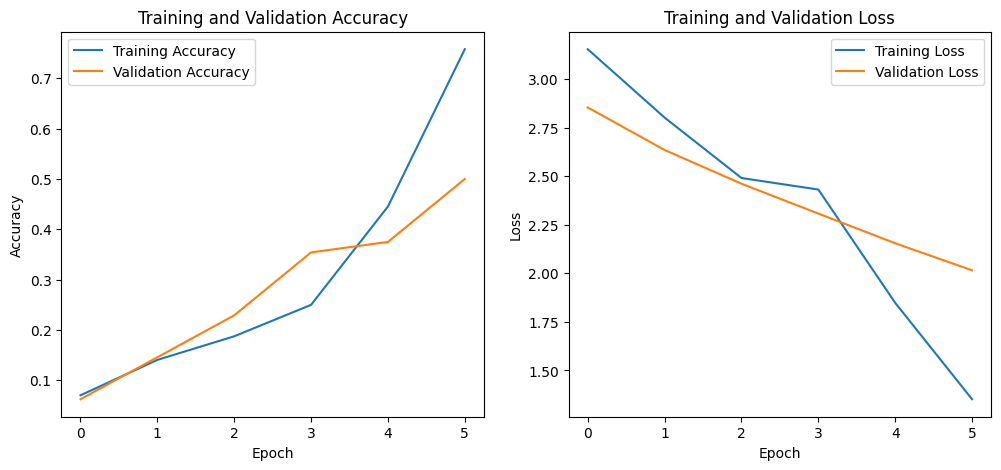

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

  abrostola_tripartita       0.00      0.00      0.00         3
   abrostola_triplasia       0.00      0.00      0.00         3
    achlya_flavicornis       0.40      0.67      0.50         3
      acronicta_aceris       1.00      1.00      1.00         3
    acronicta_leporina       1.00      0.67      0.80         3
 acronicta_megacephala       0.67      0.67      0.67         3
         acronicta_psi       0.50      0.33      0.40         3
             aglia_tau       1.00      0.67      0.80         3
  agriopis_aurantiaria       0.33      0.67      0.44         3
agriopis_leucophaearia       0.75      1.00      0.86         3
   agriopis_marginaria       0.50      0.67      0.57         3
      agrochola_litura       0.50      0.67      0.57         3
      agrochola_lunosa       0.00      0.00      0.00         3
   agrochola_macilenta       0.17      0.33      0.22         3
 agrotis_exclamationis       0.40      

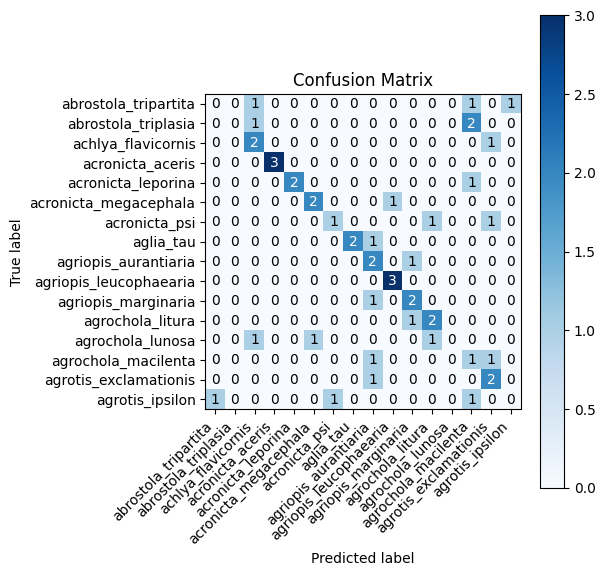

In [12]:
# @title 8-Visualizing Evaluation Results
def combine_history(h1, h2):
  history = {}
  for key in h1.history.keys():
      history[key] = h1.history[key] + h2.history[key]
  return history

history = combine_history(hist, hist_ft)

# Plot training vs validation accuracy and loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


y_true = []
y_pred = []
for imgs, labels in val_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)


thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [13]:
# @title 9-Export Trained Model and Class Labels
import os, io, pathlib, contextlib, warnings
import tensorflow as tf
from absl import logging as absl_logging

# ---- Silence TF/absl logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
absl_logging.set_verbosity(absl_logging.ERROR)
warnings.filterwarnings("ignore")

OUTPUT_DIR = os.path.abspath(OUTPUT_DIR)
pathlib.Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

def _silent(fn, *args, **kwargs):
    """Run fn(*args, **kwargs) with stdout/stderr swallowed."""
    f_out, f_err = io.StringIO(), io.StringIO()
    with contextlib.redirect_stdout(f_out), contextlib.redirect_stderr(f_err):
        return fn(*args, **kwargs)

# ---------- 1) .keras (native)
keras_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.keras")
_silent(model.save, keras_path)

# ---------- 2) .h5 (legacy) — İSTEMİYORSAN bu bloğu tamamen kaldırabilirsin
h5_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.h5")
try:
    _silent(model.save, h5_path)  # .h5 kaydında çıkan absl uyarısı da yutulur
except Exception:
    pass

# ---------- 3) SavedModel
sm_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}_savedmodel")
try:
    if hasattr(model, "export"):   # Keras 3
        _silent(model.export, sm_path)   # endpoint/ captures çıktısını susturur
    else:
        _silent(tf.saved_model.save, model, sm_path)
except Exception:
    sm_path = None

# ---------- 4) TFLite
if sm_path and os.path.isdir(sm_path):
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(sm_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = _silent(converter.convert)
        with open(os.path.join(OUTPUT_DIR, f"{BACKBONE}.tflite"), "wb") as f:
            f.write(tflite_model)
    except Exception:
        pass

# ---------- 5) class_names.txt (varsa)
try:
    class_txt = os.path.join(OUTPUT_DIR, "class_names.txt")
    if "class_names" in globals() and isinstance(class_names, (list, tuple)):
        with open(class_txt, "w", encoding="utf-8") as f:
            for c in class_names: f.write(str(c) + "\n")
    elif "DATA_DIR" in globals() and os.path.isdir(os.path.join(DATA_DIR, "train")):
        classes = sorted([
            d for d in os.listdir(os.path.join(DATA_DIR, "train"))
            if os.path.isdir(os.path.join(DATA_DIR, "train", d))
        ])
        if classes:
            with open(class_txt, "w", encoding="utf-8") as f:
                for c in classes: f.write(str(c) + "\n")
except Exception:
    pass

print("Output Folder:", OUTPUT_DIR)


Output Folder: /content/output


In [14]:
# @title 10-Save & Download the Model

btn_keras = widgets.Button(
    description="Download .keras",
    button_style='primary',
    layout=widgets.Layout(width="500px", height="100px")
)
btn_h5 = widgets.Button(
    description="Download .h5",
    button_style='primary',
    layout=widgets.Layout(width="500px", height="100px")
)
btn_tflite = widgets.Button(
    description="Download .tflite",
    button_style='primary',
    layout=widgets.Layout(width="500px", height="100px")
)

btn_savedmodel = widgets.Button(
    description="Download SavedModel (.zip)",
    button_style='info',
    layout=widgets.Layout(width="500px", height="100px")
)

btn_all = widgets.Button(
    description="Download ALL outputs (.zip)",
    button_style='success',
    layout=widgets.Layout(width="500px", height="60px")
)

widgets.HBox([btn_keras, btn_tflite, btn_savedmodel, btn_all])


# --- Paths (re-derive defensively in case the user runs this cell alone) ---
keras_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.keras")
h5_file_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.h5")
tflite_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}.tflite")
sm_dir     = os.path.join(OUTPUT_DIR, f"{BACKBONE}_savedmodel")

savedmodel_zip = os.path.join(OUTPUT_DIR, f"{BACKBONE}_savedmodel.zip")
all_outputs_zip = os.path.join(OUTPUT_DIR, f"{BACKBONE}_all_outputs.zip")

# --- Buttons ---
btn_h5 = widgets.Button(description="Download .h5", button_style='primary')
btn_keras = widgets.Button(description="Download .keras", button_style='primary')
btn_tflite = widgets.Button(description="Download .tflite", button_style='primary')
btn_savedmodel = widgets.Button(description="Download SavedModel (.zip)", button_style='primary')
btn_all = widgets.Button(description="Download ALL outputs (.zip)", button_style='primary')

out = widgets.Output()

# --- Callbacks ---

btn_keras.on_click(on_click_keras)
btn_h5.on_click(on_click_h5)
btn_tflite.on_click(on_click_tflite)
btn_savedmodel.on_click(on_click_savedmodel)
btn_all.on_click(on_click_all)

# --- UI layout ---
box = widgets.VBox([
    widgets.HTML("<h2>Download trained model files</h2>"
                 "<p>Click the button below to download your trained model files.If you don’t see the files, make sure you have completed the training step first.</p>"),
    widgets.HBox([btn_keras, btn_tflite, btn_h5]),
    widgets.HBox([btn_savedmodel, btn_all]),
    out
])

display(box)

btn = widgets.Button(
    description="Download class_names.txt",
    button_style="success",
    icon="download",
    layout=widgets.Layout(width="auto")
)



btn.on_click(_on_click)
display(btn)

Button(button_style='success', description='Download class_names.txt', icon='download', layout=Layout(width='a…